This post is the first in a series of articles about [natural language processing](https://en.wikipedia.org/wiki/Natural_language_processing) (NLP), a subfield of machine learning concerning interaction between computers and human language. This article will be focused on *attention*, a mechanism that forms the backbone of many state-of-the art language models, including Google's BERT ([Devlin et al., 2018](https://arxiv.org/abs/1810.04805)), and OpenAI's GPT-2 ([Radford et al., 2019](https://openai.com/blog/better-language-models/)). 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/teddykoker/blog/blob/master/_notebooks/2020-02-25-nlp-from-scratch-annotated-attention.ipynb)

First introduced in the paper *Neural Machine Translation by Jointly Learning to Align and Translate* ([Bahdanau et al., 2014](https://arxiv.org/abs/1409.0473)), attention was an improvement to the classic sequence-to-sequence model for language translation. Instead of trying to decode a translated sentence from single fixed-length vector encoding of the source sentence, the attention mechanism aims to create an alignment between the source words and target words. This alignment allows the model to take all of the source words into account when predicting each target word.

The next two sections of this post will consist of portions of the paper *Effective Approaches to Attention-based Neural Machine Translation* ([Luong et al., 2015](https://arxiv.org/abs/1508.04025)) along with my own comments and code in blockquotes.

> Before continuing, it is important to have an understanding of LSTM netoworks. [Here](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) is a great resource. The format of this post was inspired [The Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html).

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm.notebook import tqdm
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## Attention-based Models

Our various attention-based models are classified
into two broad categories, global and local. These
classes differ in terms of whether the "attention"
is placed on all source positions or on only a few
source positions. We illustrate these two model
types in Figure 2 and 3 respectively.
    
Common to these two types of models is the fact
that at each time step $t$ in the decoding phase, both
approaches first take as input the hidden state ht
at the top layer of a stacking LSTM. The goal is
then to derive a context vector $c_t$
that captures relevant source-side information to help predict the
current target word $y_t$. While these models differ
in how the context vector $c_t$
is derived, they share
the same subsequent steps.
Specifically, given the target hidden state $h_t$ and
the source-side context vector $c_t$, we employ a
simple concatenation layer to combine the information from both vectors:

$$ \tilde{h_t} = \tanh(W_c[c_t;h_t])     $$

The attentional vector $\tilde{h_t}$
is then fed through the
softmax layer to produce the predictive distribution formulated as:

$$p(y_t | y_{\lt t}, x) = \text{softmax}(W_s\tilde{h_t}) $$

The attentional vector $\tilde{h_t}$
is then fed through the
softmax layer to produce the predictive distribution formulated as:

> With this information we can implement the decoder portion of our model, leaving the context vector $c_t$ to be calculated by our (not yet written) `Attention` module.

In [45]:
class Decoder(nn.Module):
    """
    Decode output from hidden state and context
    """
    def __init__(self, output_dim, embed_dim, hidden_dim, num_layers, dropout):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.embed = nn.Embedding(output_dim, embed_dim)
        # stacking LSTM
        self.lstm = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout=dropout)
        self.attention = Attention(hidden_dim) # we'll get to later
        self.wc = nn.Linear(hidden_dim * 2, hidden_dim)
        self.ws = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, hidden, encoder_out):
        trg = trg.unsqueeze(0)
        embed = self.dropout(self.embed(trg))
        decoder_out, hidden = self.lstm(embed, hidden)
        
        # we'll go over how these are computed later
        atten, context = self.attention(decoder_out, encoder_out)
        
        # "We employ a simple concatenation layer to combine the 
        # information from both vectors:"
        atten_hidden = self.wc(torch.cat((decoder_out, context), dim=2)).tanh()

        # "The attentional vector ~h_t is then fed through the softmax layer
        # to produce the predictive distribution:"
        out = self.ws(atten_hidden.squeeze(0))
        # softmax will be included in loss function
        
        return out, hidden, atten

We now detail how each model type computes
the source-side context vector $c_t$

![](global_attention.png)

Figure 2: **Global attentional model** - at each time
step $t$, the model infers a variable-length alignment weight vector $a_t$ based on the current target
state $h_t$ and all source states $\overline{h}_s$. A global context vector $c_t$
is then computed as the weighted average, according to $a_t$, over all the source state

## Global Attention

The idea of a global attentional model is to consider all the hidden states of the encoder when deriving the context vector $c_t$. In this model type, a variable-length alignment vector $a_t$, whose size
equals the number of time steps on the source side,
is derived by comparing the current target hidden
state $h_t$ with each source hidden state $\overline{h}_s$:

$$ a_t(s)=\text{align}(h_t, \overline{h}_s) $$

$$ =\frac{\exp(\text{score}(h_t, \overline{h}_s))}{\sum_{s'}\exp(\text{score}(h_t, \overline{h}_{s'}))}$$

Here, $\text{score}$ is referred as a content-based function
for which we consider three different alternatives:

$$
\text{score}(h_t, \overline{h}_s)\!=\!\begin{cases}
    h_t^\top \overline{h}_s & dot\\
    h_t^\top W_a \overline{h}_s & general\\
    v_a^\top \tanh(W_a[h_t;\overline{h}_s]) & concat
\end{cases}
$$


Given the alignment vector as weights, the context
vector $c_t$ is computed as the weighted average over
all the source hidden states.

In [46]:
class Attention(nn.Module):
    """
    Compute alignment vector and context vector from hidden states
    """
    def __init__(self, hidden_dim, score_fn="general"):
        super(Attention, self).__init__()
        self.score_fn = score_fn
        if score_fn == "general":
            self.w = nn.Linear(hidden_dim, hidden_dim)
        if score_fn == "concat":
            self.w = nn.Linear(hidden_dim * 2, hidden_dim)
            self.v = torch.nn.Parameter(torch.FloatTensor(hidden_dim))
            
    def score(self, decoder_out, encoder_outs):
        if self.score_fn == "dot":
            return torch.sum(decoder_out * encoder_outs, dim=2)
        if self.score_fn == "general":
            return torch.sum(decoder_out * self.w(encoder_outs), dim=2)
        if self.score_fn == "concat":
            decoder_outs = decoder_out.repeat(encoder_outs.shape[0], 1, 1)
            cat = torch.cat((decoder_outs, encoder_outs))
            return torch.sum(self.v * self.w(cat), dim=2)
            
    def forward(self, decoder_out, encoder_outs):
        score = self.score(decoder_out, encoder_outs)
        a = F.softmax(score, dim=0)
            
        # "Given the alignment vector as weights, the context vector 
        # c_t is computed as the weighted average over all the source 
        # hidden states:"
        context = torch.bmm(
            a.transpose(1, 0).unsqueeze(1),
            encoder_outs.transpose(1, 0)
        ).transpose(1, 0)
        return a, context

> We implemented an attention model that can perform each of the three $\text{score}$ functions depending on the parameter `score_fn`. *Note: for brevity, we have skipped over the local attention portion of the paper*. With the `Attention` and `Decoder` modules complete, all we need now is a simple encoder, consisting of some stacked LSTMs and a model that puts all of the modules together:

In [47]:
class Encoder(nn.Module):
    """
    Stacked LSTM encoder
    """
    def __init__(self, input_dim, embed_dim, hidden_dim, 
                 n_layers, dropout):
        super(Encoder, self).__init__()
        self.embed = nn.Embedding(input_dim, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout) 
        
    def forward(self, src):
        embed = self.dropout(self.embed(src))
        out, hidden = self.lstm(embed)
        return self.dropout(out), hidden
    

class Model(nn.Module):
    """
    Sequence to Sequence model with attention
    """
    def __init__(self, encoder, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, src, trg, teacher_force_ratio = 0.5):
        outs = torch.zeros(
            trg.shape[0], trg.shape[1], self.decoder.output_dim
        ).to(src.device)
        encoder_out, hidden = self.encoder(src)
        
        x = trg[0]
        for t in range(1, trg.shape[0]):
            outs[t], hidden, _ = self.decoder(x, hidden, encoder_out)
            x = trg[t] if random.random() < teacher_force_ratio else outs[t].argmax(1)
            
        return outs

> With the model implementation complete, we are ready to train. The remainder of the post will be my own words and figures.

## Experiments

The original paper trained and evaluated on the [WMT14](http://www.statmt.org/wmt14/translation-task.html) German-English translation task, with a training set of 4.5 million sentence pairs. Since their implementation took "7 - 10 days to completely train a model," we will opt for a much smalling training/evaluation dataset: Multi30K ([Elliott et al., 2016](https://arxiv.org/abs/1605.00459)). This dataset consists of 30 thousand English-German sentence pairs, and we will be able to train the model on a single GPU in less than 31 minutes.

In [48]:
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
import spacy

# tokenizers
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')
tokenize_de = lambda text: [tok.text for tok in spacy_de.tokenizer(text)]
tokenize_en = lambda text: [tok.text for tok in spacy_en.tokenizer(text)]

# fields
SRC = Field(tokenize=tokenize_de, init_token='<sos>',
            eos_token="<eos>", lower=True)
TRG = Field(tokenize=tokenize_de, init_token='<sos>',
            eos_token="<eos>", lower=True)

# data
train_data, valid_data, test_data = Multi30k.splits(('.de', '.en'), (SRC, TRG))
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

Since we're working with less data, we can make our model smaller as well. The paper uses 4 layers for their LSTM models, each with 1000 cells, and 1000-dimensional embeddings. We will use 2 layers for our LSTM models, each with 512 cells, and 256-dimensional embeddings. We will, however, use the same dropout probability (0.2), batch size (128) and uniform weight initialization ($[-0.1, 0.1]$):

In [49]:
input_dim = len(SRC.vocab)
output_dim = len(TRG.vocab)
embed_dim = 256
hidden_dim = 512
n_layers = 2
dropout = 0.2
batch_size = 128
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def init_weights(model):
    for param in model.parameters():
        nn.init.uniform_(param.data, -0.1, 0.1)

train_loader, valid_loader, test_loader = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=batch_size,
    device=device
)

encoder = Encoder(input_dim, embed_dim, hidden_dim, n_layers, dropout)

decoder = Decoder(output_dim, embed_dim, hidden_dim, n_layers, dropout)
model = Model(encoder, decoder).to(device)
model.apply(init_weights);

### Training

We now fit the model to our training set using the Adam optimizer and cross-entropy loss:

In [50]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=TRG.vocab.stoi[TRG.pad_token])
num_epochs = 10

def step(model, data, criterion, train=False, optimizer=None):
    model.train() if train else model.eval()
    total_loss = 0
    for batch in tqdm(data, leave=False):
        if train: optimizer.zero_grad()
        pred = model(batch.src, batch.trg)
        loss = criterion(pred.view(-1, pred.size(2)), batch.trg.view(-1))
        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data)

best_loss = float('inf')
train_loss, valid_loss = np.zeros((2, num_epochs))
for e in range(num_epochs):
    train_loss[e] = step(model, train_loader, criterion, train=True, optimizer=optimizer)
    valid_loss[e] = step(model, valid_loader, criterion)
    #print(f"epoch: {e} train_loss: {train_loss[e]:.2f} valid_loss: {valid_loss[e]:.2f}")
    if valid_loss[e] < best_loss:
        torch.save(model.state_dict(), 'model.pt')
        best_loss = valid_loss[e]

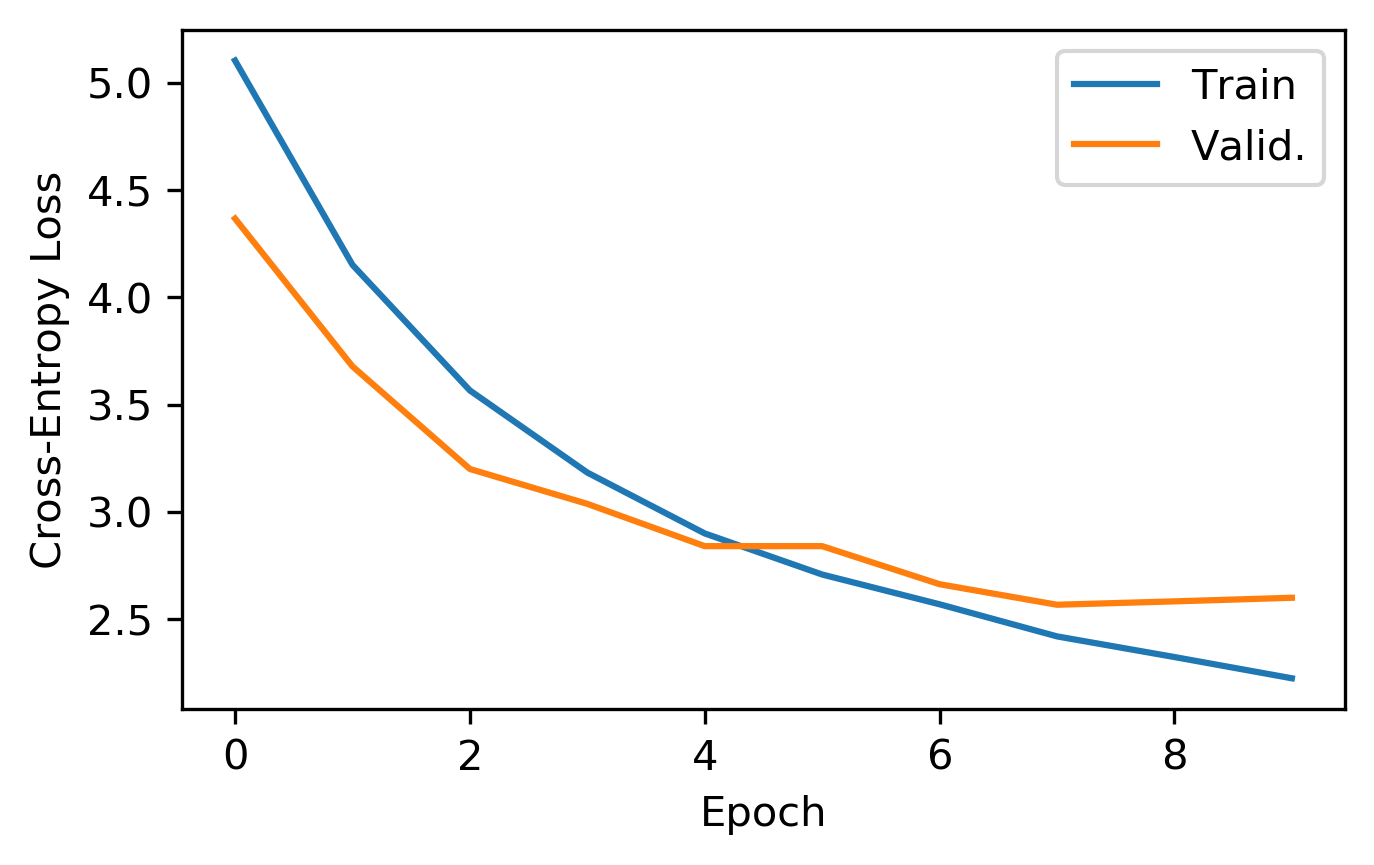

In [51]:
plt.figure(figsize=(5, 3), dpi=300)
plt.plot(train_loss[:10], label="Train")
plt.plot(valid_loss[:10], label="Valid.")
plt.legend(); plt.ylabel("Cross-Entropy Loss"); plt.xlabel("Epoch")
plt.show()

### Evaluation

Now that we have a trained model, we can test it on our test set. In addition to cross-entropy loss, another good metric we can use is [perplexity](https://en.wikipedia.org/wiki/Perplexity), which is a measurement of the models ability to predict the target translation. This can be calculated as simply $\exp(H(p))$, where $H(p)$ is the cross-entropy loss of the model over the test set. The lower the perplexity, the better the model is at predicting the target translation.

In [66]:
model.load_state_dict(torch.load("model.pt"))
test_loss = step(model, test_loader, criterion)
print(f"Test loss: {test_loss:.2f}")
print(f"Test perplexity: {np.exp(test_loss):.2f}")

Test loss: 2.63
Test perplexity: 13.84


Our model achieves a perplexity of 13.84. This is worse then the paper's best perplexity of 5.9, but there is no way to directly compare as we are using a different dataset. There are a few ways we could improve the model to better match the papers results:

1. Use bidirectional LSTM models; The model should be able to better "understand" the context of each word by looking at words both before and after each word.

2. More training data; The model could likely benefit from more training data, such as the aforementioned WMT14 dataset.

3. Larger model and ensemble; The paper used a much larger model, and a technique known as [ensemble learning](https://en.wikipedia.org/wiki/Ensemble_learning). By combining multiple model's outputs into one, we could obtain better predictive performance.

With that out of the way, lets run our model on some test sentences!

In [53]:
@torch.no_grad()
def translate(sentence, model, device, max_len=50):
    model.eval()
    src = SRC.process([sentence]).to(device)
    trg = torch.ones(1, dtype=torch.int64).to(device) * TRG.vocab.stoi[TRG.init_token]
    trgs, attention = [], []
    encoder_out, hidden = model.encoder(src)
    
    for t in range(max_len):
        trg, hidden, atten = model.decoder(trg, hidden, encoder_out)
        trg = trg.argmax(1)
        trgs.append(trg)
        attention.append(atten.T)
        if trg == TRG.vocab.stoi[TRG.eos_token]: break

    trg = [TRG.vocab.itos[i] for i in trgs]
    src = [SRC.vocab.itos[i] for i in src]
    attention = torch.cat(attention).cpu().numpy()[:-1, 1:]
    return src, trg, attention

Let's take a look at our first example:

In [54]:
example = 6
src, trg = test_data[example].src, test_data[example].trg
print(f"Source: {' '.join(src)}")
print(f"Target: {' '.join(trg)}")

Source: eine gruppe von menschen steht vor einem iglu .
Target: a group of people standing in front of an igloo .


And now our predicted translation:

In [55]:
src, pred, attention = translate(src, model, device)
print(f"Prediction: {' '.join(pred[:-1])}")

Prediction: a group of people standing in front of an igloo .


Not bad; let's try another:

In [61]:
example = 1
src, trg = test_data[example].src, test_data[example].trg
print(f"Source: {' '.join(src)}")
print(f"Target: {' '.join(trg)}")

Source: ein boston terrier läuft über saftig-grünes gras vor einem weißen zaun .
Target: a boston terrier is running on lush green grass in front of a white fence .


In [62]:
src, pred, attention = translate(src, model, device)
print(f"Prediction: {' '.join(pred[:-1])}")

Prediction: an <unk> dog runs through the grass in front of a white fence .


The model did not have the word "boston" in it's vocabulary, so it was unable to translate that word. Although the sentences are not perfect translations, they are fairly coherent, and certainly better than a human could do with half an hour of learning German. One great thing about the model is that we can view the alignment weights $a_t$, and see which source word the model is "concentrating" on for each output word.

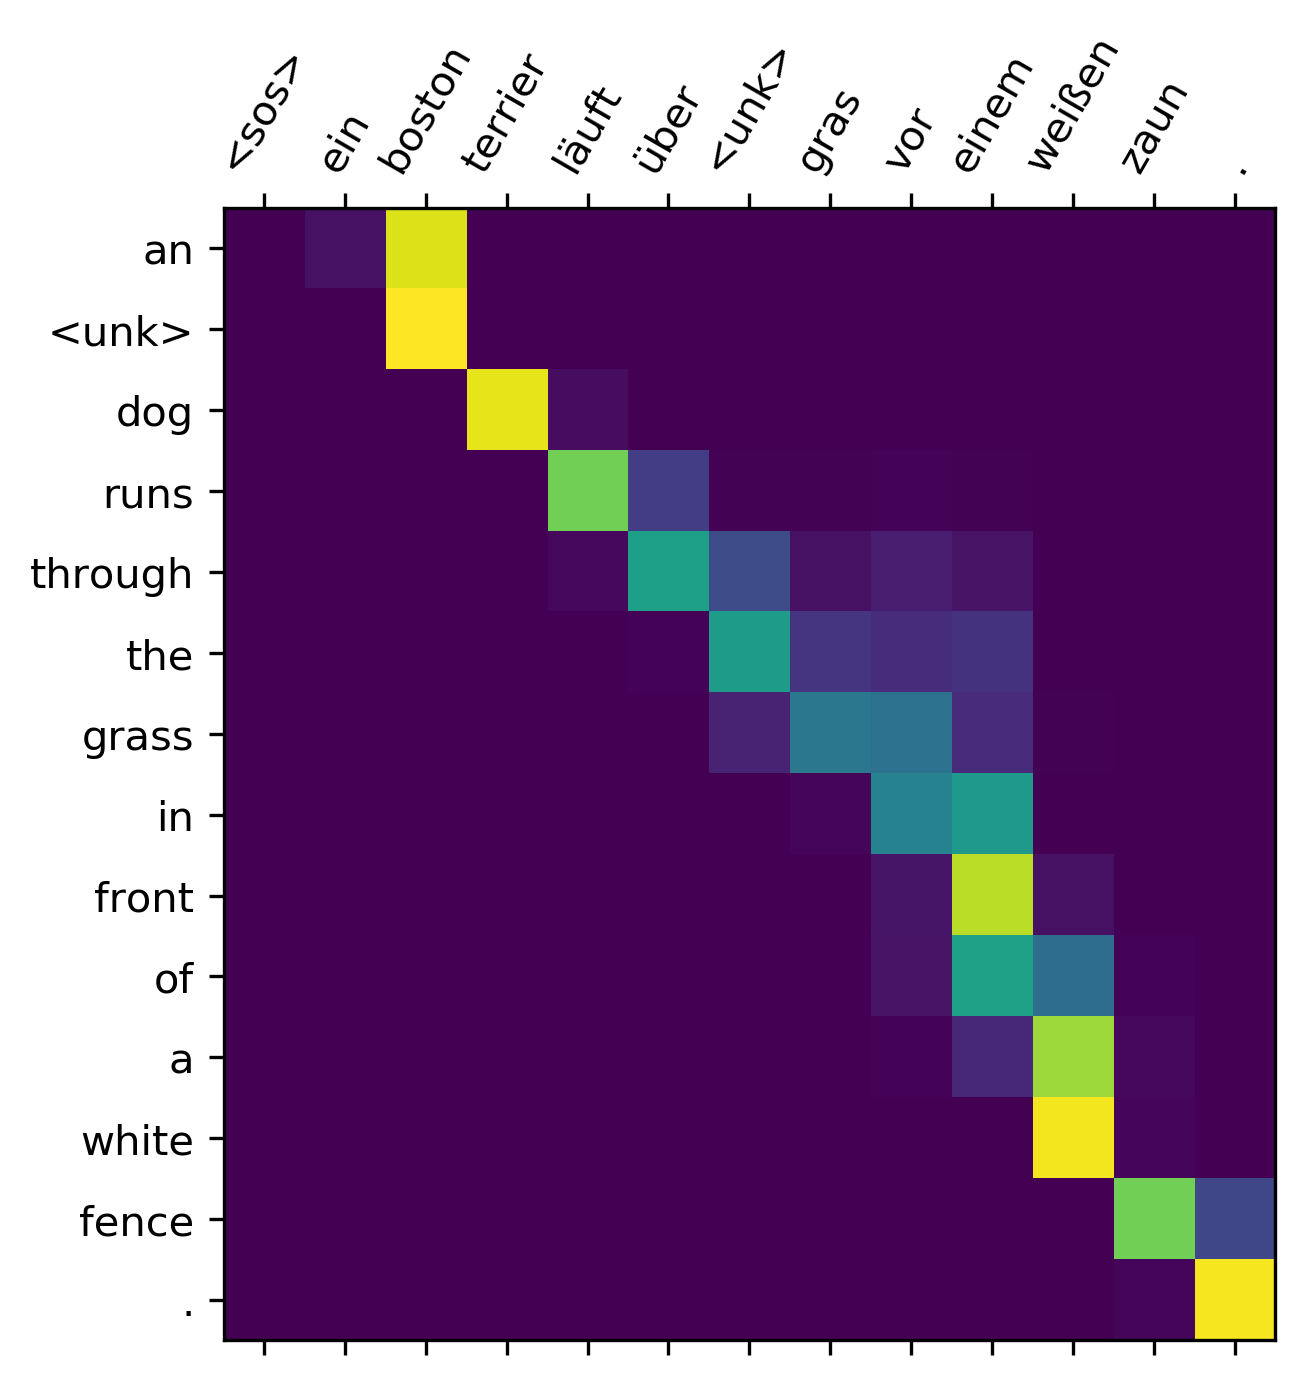

In [63]:
def plot_attention(src, trg, attention):
    fig = plt.figure(figsize=(5, 5), dpi=300)
    ax = fig.add_subplot(111)
    ax.matshow(attention)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xticklabels([''] + src, rotation=60)
    ax.set_yticklabels([''] + trg) 
    
plot_attention(src, pred, attention)

We can see that model aligns each German source word with one of the predicted words. Terrier with dog, läuft with runs, ... etc. 

## Conclusion

Attention is an important concept to know when it comes to understanding the current state-of-the-art language models. Now that we've created a simple implementation for machine translation, we'll be able to expand upon this model for different tasks. Stay tuned for my next post, where we'll create a small version of Google's BERT ([Devlin et al., 2018](https://arxiv.org/abs/1810.04805)) from scratch. Be sure to follow me on [twitter](https://twitter.com/teddykoker) for updates! This notebook can be found on [Github](https://github.com/teddykoker/blog/blob/master/_notebooks/2020-02-25-nlp-from-scratch-annotated-attention.ipynb), or be run on [Google Colab](https://colab.research.google.com/github/teddykoker/blog/blob/master/_notebooks/2020-02-25-nlp-from-scratch-annotated-attention.ipynb)